# FIT5202 Assignment 1 - Part B

## Step 01: Import pyspark and initialise Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# Importing necessary documents and libraries and creating entry points to spark
from datetime import datetime
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

sc = SparkContext.getOrCreate()

conf = SparkConf().setMaster("local[*]")\
                  .setAppName("FIT5202 Assignment 1 - Part B")
if sc == None:
    sc = SparkContext(conf=conf)

spark = SparkSession(sparkContext=sc)\
        .builder\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/FIT5202.Ass1PartB")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/FIT5202.Ass1PartB")\
        .getOrCreate()

## Step 02: Create dataframe

In [2]:
crimes = spark.read.csv("Crime_Statistics_SA_2010_present.csv", header=True, inferSchema=True)
crimes = crimes.na.drop()
crimes.show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

## Step 03: Write to Database

In [3]:
crimes.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 04: Read from Database

In [4]:
crimes_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
crimes_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 05: Calculate the statistics of numeric and string columns

In [5]:
# The report count each day on all the dates
crime_by_date = crimes_df.groupBy("Reported Date")\
                         .sum("Offence Count")\
                         .withColumnRenamed("sum(Offence Count)", "Count")\
                         .withColumnRenamed("Reported Date", "Date")
crime_by_date.show()

+----------+-----+
|      Date|Count|
+----------+-----+
|12/08/2016|  303|
|31/08/2016|  286|
|13/08/2010|  342|
|31/07/2012|  276|
| 6/10/2011|  333|
|27/11/2011|  269|
| 9/01/2014|  241|
|12/01/2012|  303|
|26/03/2015|  283|
|24/04/2016|  235|
|24/05/2017|  269|
|27/03/2014|  276|
|24/05/2016|  308|
|22/02/2012|  286|
|25/04/2013|  222|
| 4/06/2013|  268|
|27/08/2016|  299|
|30/06/2013|  283|
|11/09/2011|  305|
| 4/01/2016|  349|
+----------+-----+
only showing top 20 rows



In [6]:
# The average value of daily offence count
avg_count = crime_by_date.groupBy()\
                         .avg("Count")\
                         .withColumnRenamed("avg(Count)", "Average Offence Count")
avg_count.show()

+---------------------+
|Average Offence Count|
+---------------------+
|   300.83362769339453|
+---------------------+



In [7]:
# The standard deviation of daily offence count
std_count = crime_by_date.groupBy()\
                         .agg(stddev("Count"))\
                         .withColumnRenamed("stddev_samp(Count)", "Standard Deviation")
std_count.show()

+------------------+
|Standard Deviation|
+------------------+
|44.445236238045645|
+------------------+



In [8]:
# The maximum and minimal daily report count
max_count = crime_by_date.groupBy()\
                         .max("Count")\
                         .withColumnRenamed("max(Count)", "MaxCount")
max_count.show()

min_count = crime_by_date.groupBy()\
                         .min("Count")\
                         .withColumnRenamed("min(Count)", "MinCount")
min_count.show()

+--------+
|MaxCount|
+--------+
|     494|
+--------+

+--------+
|MinCount|
+--------+
|     133|
+--------+



The cell below shows the date when the maximum and minimum number of reports happened:

In [9]:
max_join = crime_by_date.join(max_count, crime_by_date.Count == max_count.MaxCount, "inner")\
                        .drop("MaxCount")

min_join = crime_by_date.join(min_count, crime_by_date.Count == min_count.MinCount, "inner")\
                        .drop("MinCount")

max_join.show()
min_join.show()

+----------+-----+
|      Date|Count|
+----------+-----+
|15/03/2011|  494|
+----------+-----+

+----------+-----+
|      Date|Count|
+----------+-----+
|25/12/2013|  133|
+----------+-----+



Since aggregation function cannot by applied on non-numeric columns, we get the minimal and maximal dates in this way:

In [10]:
# The maximum and minimal date
crime_by_date.describe().show()

+-------+---------+------------------+
|summary|     Date|             Count|
+-------+---------+------------------+
|  count|     2831|              2831|
|   mean|     null|300.83362769339453|
| stddev|     null|44.445236238045645|
|    min|1/01/2011|               133|
|    max|9/12/2018|               494|
+-------+---------+------------------+



In [11]:
crime_by_date.sort("Date", ascending=True).show()
crime_by_date.sort("Date", ascending=False).show()

+---------+-----+
|     Date|Count|
+---------+-----+
|1/01/2011|  408|
|1/01/2012|  373|
|1/01/2013|  385|
|1/01/2014|  384|
|1/01/2015|  344|
|1/01/2016|  366|
|1/01/2017|  391|
|1/01/2019|  293|
|1/02/2011|  334|
|1/02/2012|  326|
|1/02/2013|  312|
|1/02/2014|  266|
|1/02/2015|  279|
|1/02/2016|  379|
|1/02/2017|  273|
|1/02/2019|  314|
|1/03/2011|  346|
|1/03/2012|  278|
|1/03/2013|  315|
|1/03/2014|  277|
+---------+-----+
only showing top 20 rows

+---------+-----+
|     Date|Count|
+---------+-----+
|9/12/2018|  259|
|9/12/2016|  306|
|9/12/2015|  315|
|9/12/2014|  295|
|9/12/2013|  348|
|9/12/2012|  290|
|9/12/2011|  324|
|9/12/2010|  342|
|9/11/2018|  304|
|9/11/2016|  300|
|9/11/2015|  369|
|9/11/2014|  226|
|9/11/2013|  266|
|9/11/2012|  319|
|9/11/2011|  343|
|9/11/2010|  368|
|9/10/2018|  337|
|9/10/2016|  256|
|9/10/2015|  307|
|9/10/2014|  270|
+---------+-----+
only showing top 20 rows



Since the dates are stored in strings, they are compared by each characters. In this case, the date starts with '9' will be placed after the one starts with'31', which does not make any sense. In conclusion, both the minimum and maximum date are incorrect, if sorted directly in string data type.

## Step 06: Change the data type of a column

In [12]:
converter = udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
crimes_converted = crimes.withColumn("Reported Date", converter(col("Reported Date")))
crimes_converted.printSchema()
crimes_converted.count()

root
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



726921

## Step 07: Preliminary data analysis

### How many level 2 offences are there? Display the list of level 2 offences.

In [13]:
crimes_converted.groupBy("Offence Level 2 Description")\
                .count()\
                .count()

9

There are 9 types of level 2 offences. And the following cell shows the list of all the types of level 2 description of offences.

In [14]:
crimes_converted.groupBy("Offence Level 2 Description")\
                .sum("Offence Count")\
                .withColumnRenamed("sum(Offence Count)",\
                                   "Offence Count")\
                .show(truncate=False)

+------------------------------------+-------------+
|Offence Level 2 Description         |Offence Count|
+------------------------------------+-------------+
|ROBBERY AND RELATED OFFENCES        |6242         |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |200683       |
|SEXUAL ASSAULT AND RELATED OFFENCES |13974        |
|HOMICIDE AND RELATED OFFENCES       |478          |
|ACTS INTENDED TO CAUSE INJURY       |130161       |
|SERIOUS CRIMINAL TRESPASS           |115124       |
|OTHER OFFENCES AGAINST THE PERSON   |24625        |
|FRAUD DECEPTION AND RELATED OFFENCES|21525        |
|THEFT AND RELATED OFFENCES          |338848       |
+------------------------------------+-------------+



### What is the number of offences against the person?

In [15]:
crimes_converted.groupBy("Offence Level 1 Description")\
                .sum("Offence Count")\
                .withColumnRenamed("sum(Offence Count)",\
                                   "Offence Count")\
                .show(truncate=False)

+---------------------------+-------------+
|Offence Level 1 Description|Offence Count|
+---------------------------+-------------+
|OFFENCES AGAINST THE PERSON|175480       |
|OFFENCES AGAINST PROPERTY  |676180       |
+---------------------------+-------------+



There are 175480 offences against person.

### How many serious criminal tresspasses with more than 1 offence count?

In [16]:
crimes_converted.where(crimes_converted["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")\
                .groupBy("Offence Level 3 Description")\
                .count()\
                .withColumnRenamed("sum(Offence Count)",\
                                   "Offence Count")\
                .show(truncate=False)

+--------------------------------+-----+
|Offence Level 3 Description     |count|
+--------------------------------+-----+
|SCT - Residence                 |64499|
|SCT - Non Residence             |38082|
|Other unlawful entry with intent|2322 |
+--------------------------------+-----+



As we can see from the result, all three types of serious criminal trepasses are with more than 1 offence count.

### What percentage of crimes are offences against the property?


In [17]:
# Calculate the total number of offences
total = crimes_converted.groupBy().sum("Offence Count").collect()[0][0]

level1 = crimes_converted.groupBy("Offence Level 1 Description")\
                         .sum("Offence Count")\
                         .withColumnRenamed("sum(Offence Count)",\
                                            "Offence Count")\

percentage = level1.withColumn("Offence Count",\
                               level1["Offence Count"]/total*100)\
                   .withColumnRenamed("Offence Count", "Percentage")\
                   .show(truncate=False)

+---------------------------+----------------+
|Offence Level 1 Description|Percentage      |
+---------------------------+----------------+
|OFFENCES AGAINST THE PERSON|20.6044665711669|
|OFFENCES AGAINST PROPERTY  |79.3955334288331|
+---------------------------+----------------+



The percentage of offences against property is 79.40%

## Step 08: Exploratory data analysis

### Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

Text(0.5, 1.0, 'Total Criminal Offences - 2010 to 2019')

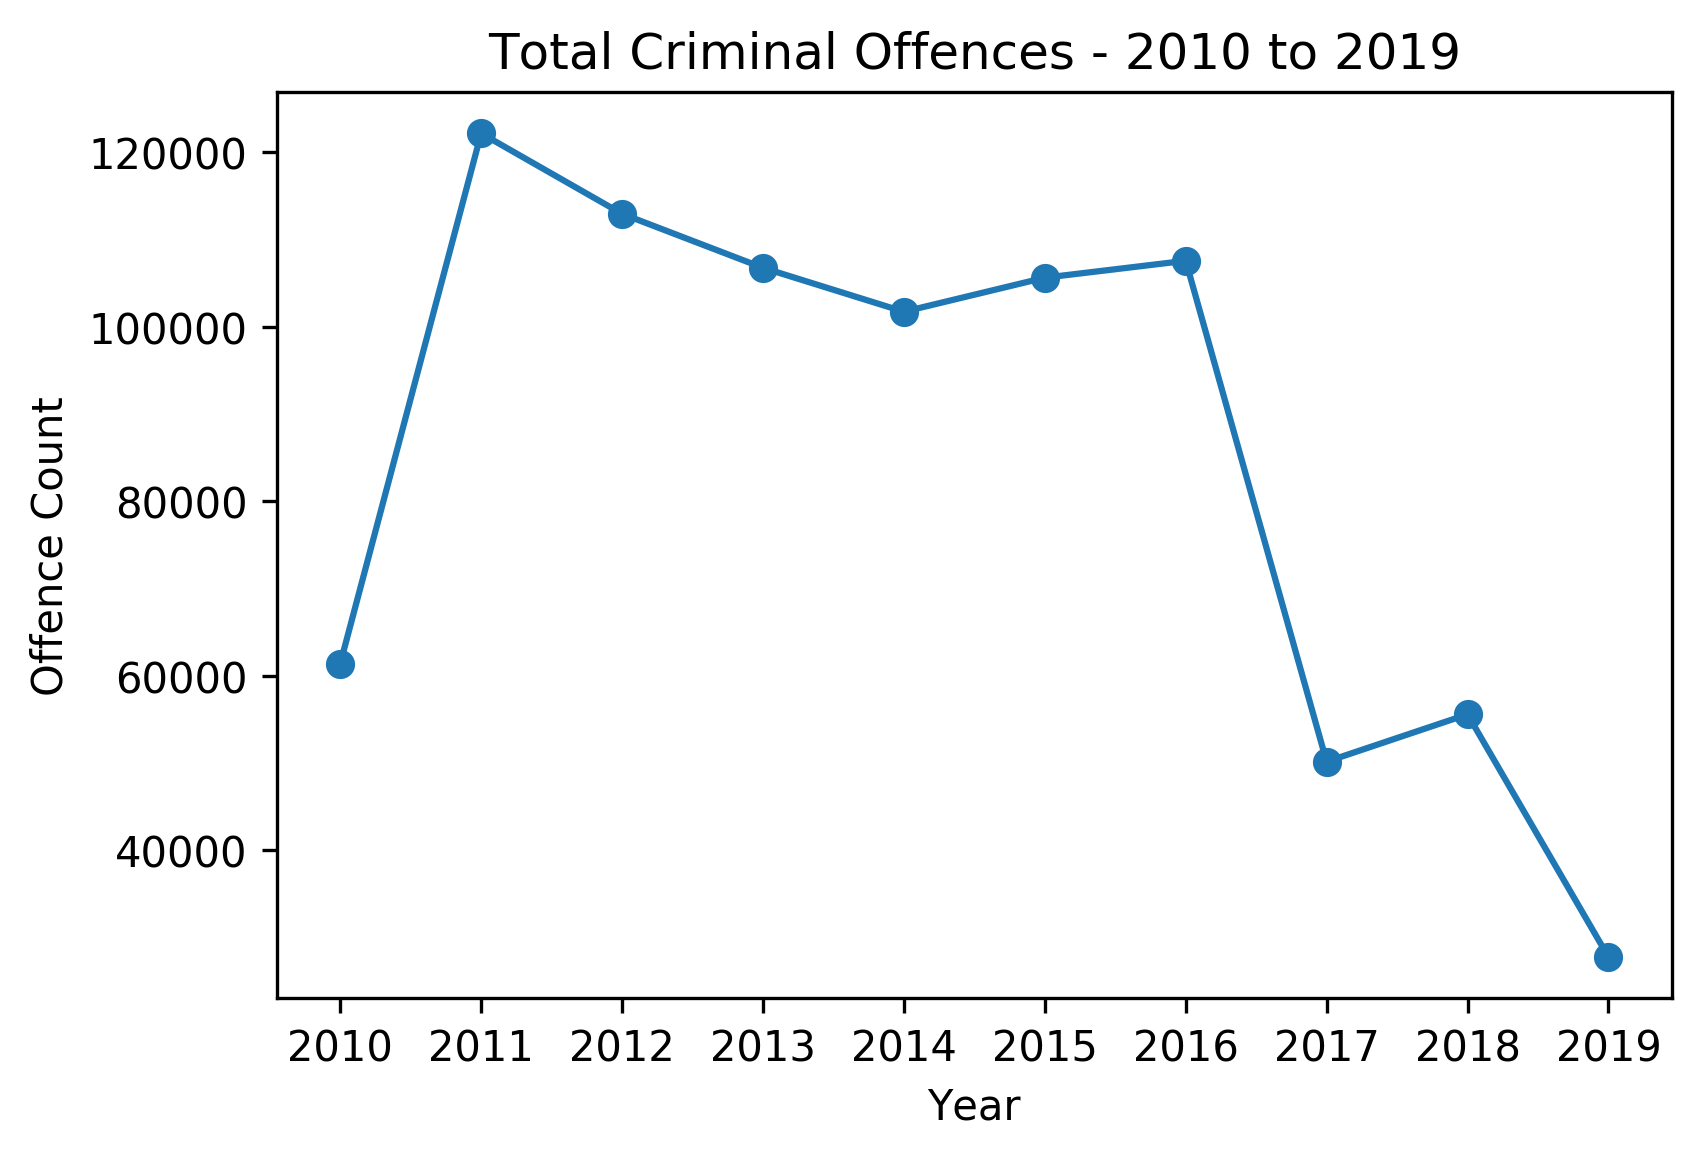

In [18]:
annual_raw = crimes_converted.groupBy(year("Reported Date"))\
                             .sum("Offence Count")\
                             .sort("year(Reported Date)", ascending=True)\
                             .collect()
annual_year = np.array([i["year(Reported Date)"] for i in annual_raw])
annual_count = np.array([i["sum(Offence Count)"] for i in annual_raw])

fig, ax = plt.subplots(dpi=300)
ax.plot(annual_year, annual_count, marker="o")
ax.set_xticks(annual_year)
ax.set_xlabel("Year")
ax.set_ylabel("Offence Count")
ax.set_title("Total Criminal Offences - 2010 to 2019")

The number of offences was pretty low in 2010, but a drastic increase happened in 2011. The total number of offences had been slowly declining from 2012 to 2014, but it started to increase slowly from 2014 to 2016. 2017 was a year of drastic decline. Though with a slight increase in  2018, the crime level among 2017, 2018 and 2019 was low.

However, this data is strongly biased, since the criminal record does not record every day from 2010 to 2019. Further investigation could be made if the data covers every single day from 2010 to now.

The cell below shows us the number of days with criminal records in each year. It is impossible that there would be a day without crime. Hence, in the line graph above, only the data from 2011 to 2016 could reflect the true level of crime of the year.

In [19]:
crimes_converted.groupBy("Reported Date")\
                .count()\
                .groupBy(year("Reported Date"))\
                .count()\
                .sort("year(Reported Date)")\
                .show()

+-------------------+-----+
|year(Reported Date)|count|
+-------------------+-----+
|               2010|  184|
|               2011|  365|
|               2012|  366|
|               2013|  365|
|               2014|  365|
|               2015|  365|
|               2016|  366|
|               2017|  181|
|               2018|  184|
|               2019|   90|
+-------------------+-----+



We decided to calculate the average criminal offences by day to get us closer to the real situation.

Text(0.5, 1.0, 'Average Criminal Offences by Day - 2010 to 2019')

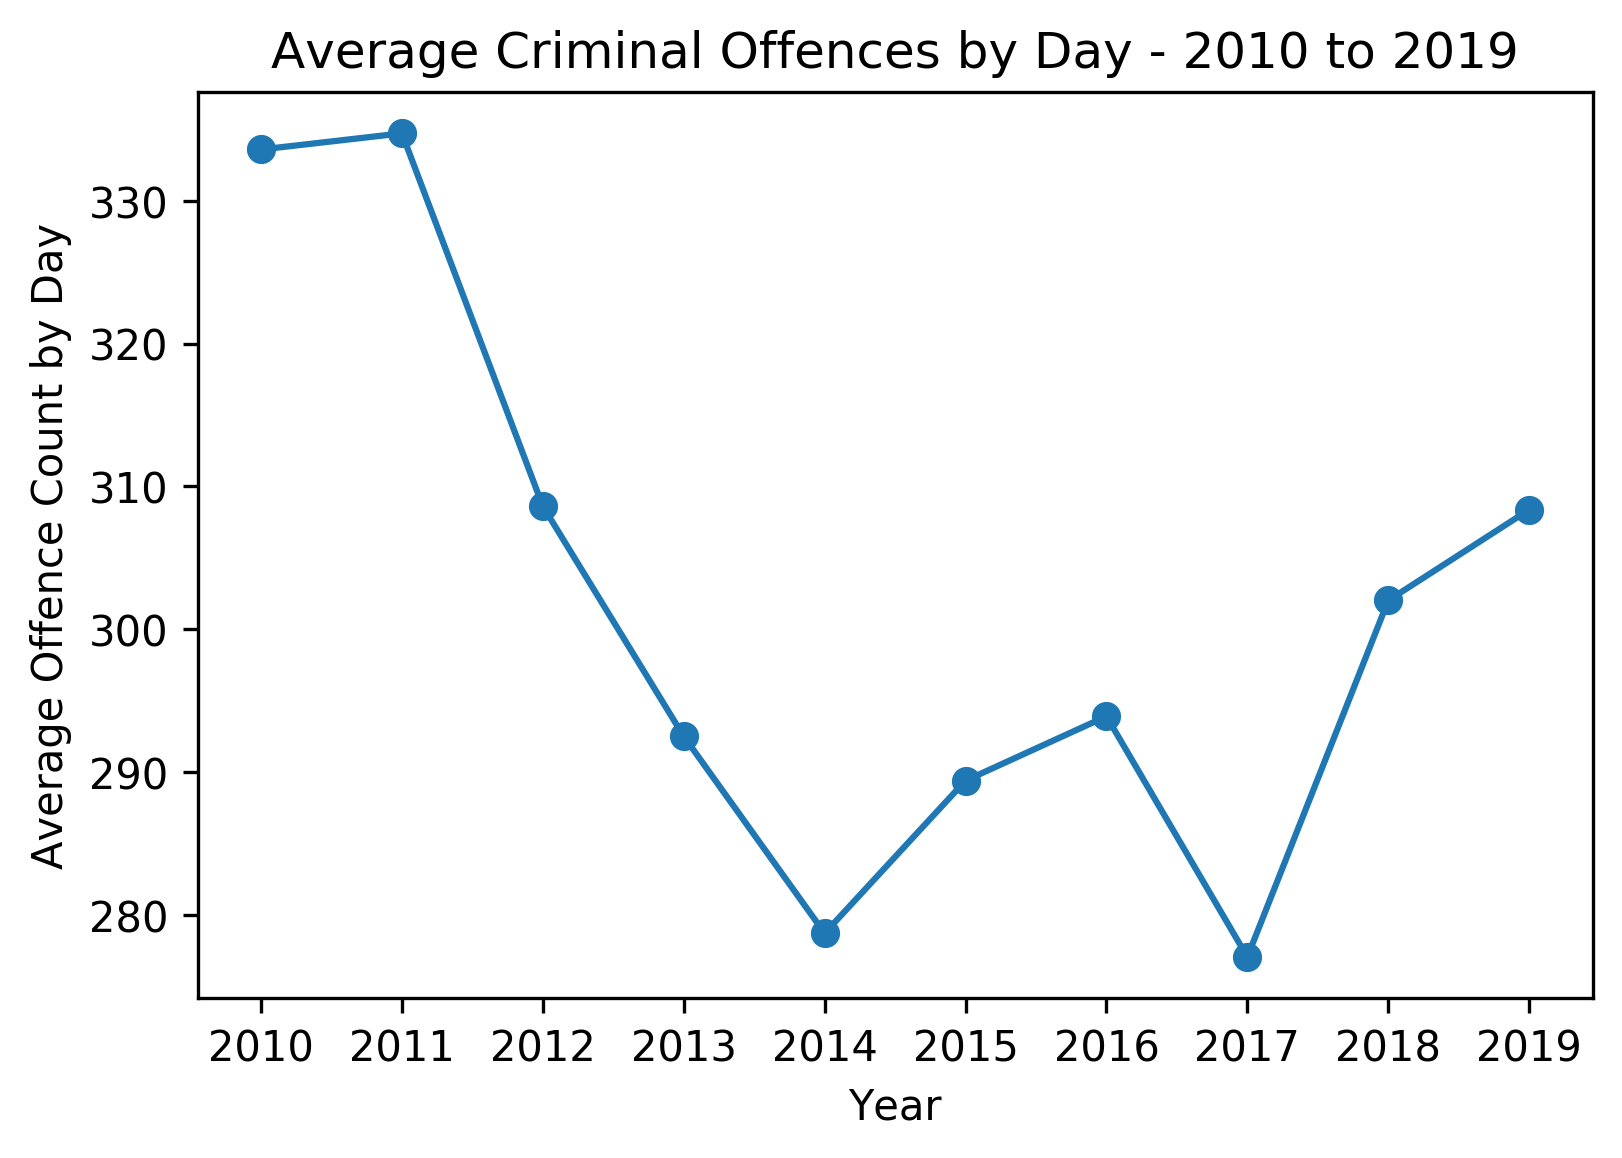

In [20]:
day_count = crimes_converted.groupBy("Reported Date")\
                            .count()\
                            .groupBy(year("Reported Date"))\
                            .count()\
                            .sort("year(Reported Date)")\
                            .collect()
day_count = np.array([i["count"] for i in day_count])

annual_avg = annual_count/day_count

fig, ax = plt.subplots(dpi=300)
ax.plot(annual_year, annual_avg, marker="o")
ax.set_xticks(annual_year)
ax.set_xlabel("Year")
ax.set_ylabel("Average Offence Count by Day")
ax.set_title("Average Criminal Offences by Day - 2010 to 2019")

This graph shows the daily average of criminal offences in different years. 2010 and 2011 are two very dangerous years, but there was a drastic decrease in the number of daily average offences along 2012 to 2014. 2015 and 2016 experienced a mild increase, but dropped back to low level in 2017. From 2018 on, the daily offence count in average has been increasing.

### Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

Text(0.5, 1.0, 'Average Offences by Month')

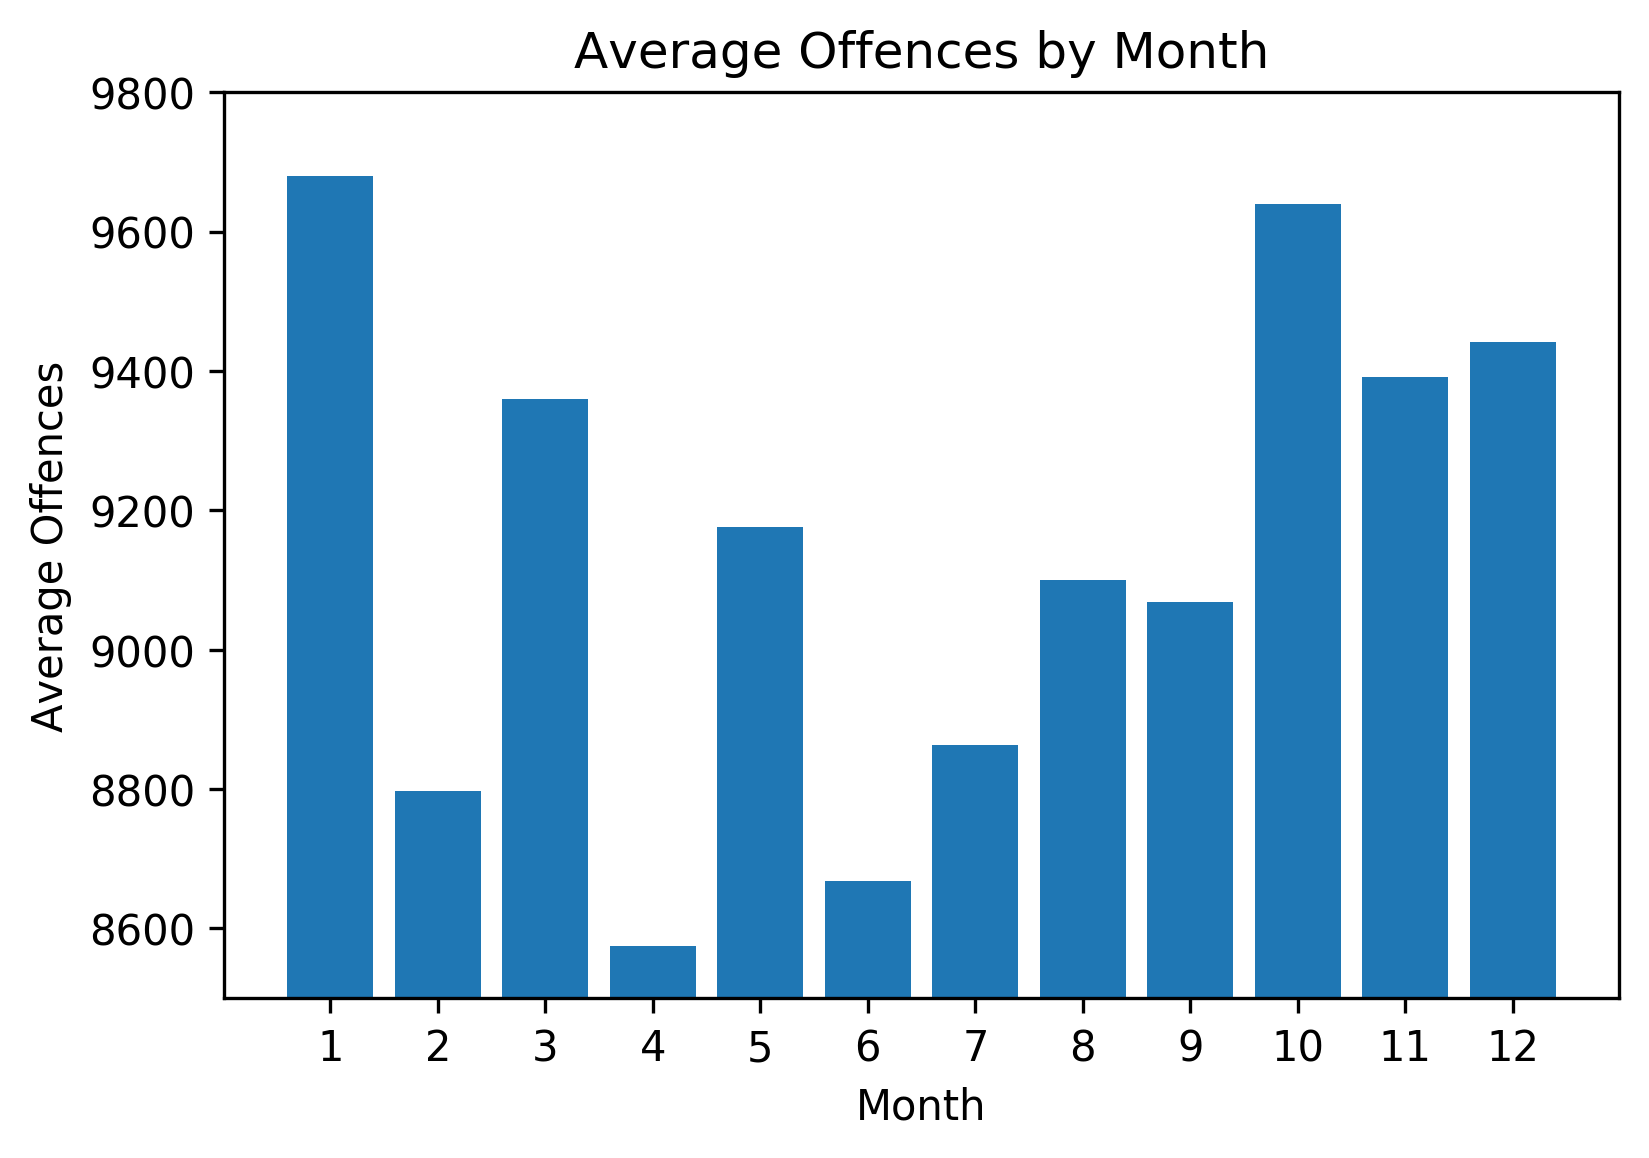

In [21]:
monthly_raw = crimes_converted.groupBy(month("Reported Date"))\
                              .sum("Offence Count")\
                              .sort("month(Reported Date)",\
                                    ascending=True)\
                              .collect()
monthly_count = crimes_converted.groupBy(year("Reported Date"), month("Reported Date"))\
                                .count()\
                                .groupBy("month(Reported Date)")\
                                .count()\
                                .sort("month(Reported Date)")\
                                .collect()

monthly_sum = np.array([i["sum(Offence Count)"] for i in monthly_raw for j in range(1, 13) if i["month(Reported Date)"] == j])
monthly_count = np.array([i["count"] for i in monthly_count for j in range(1, 13) if i["month(Reported Date)"] == j])
monthly_average = monthly_sum/monthly_count

fig, ax = plt.subplots(dpi=300)
ax.bar(list(range(1, 13)), monthly_average)
ax.set_xticks(list(range(1, 13)))
ax.set_ylim(bottom=8500, top=9800)
ax.set_xlabel("Month")
ax.set_ylabel("Average Offences")
ax.set_title("Average Offences by Month")

We set the bottom of y-axis as 8500 so we can have a clearer picture of the comparison of the average criminal offences by month. Summer months (October to January) has significantly higher number of criminal offences. February, April and June are the months with the least criminal offences in average, the causation of this phenomenon requires further investigation and more data.

### Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph.

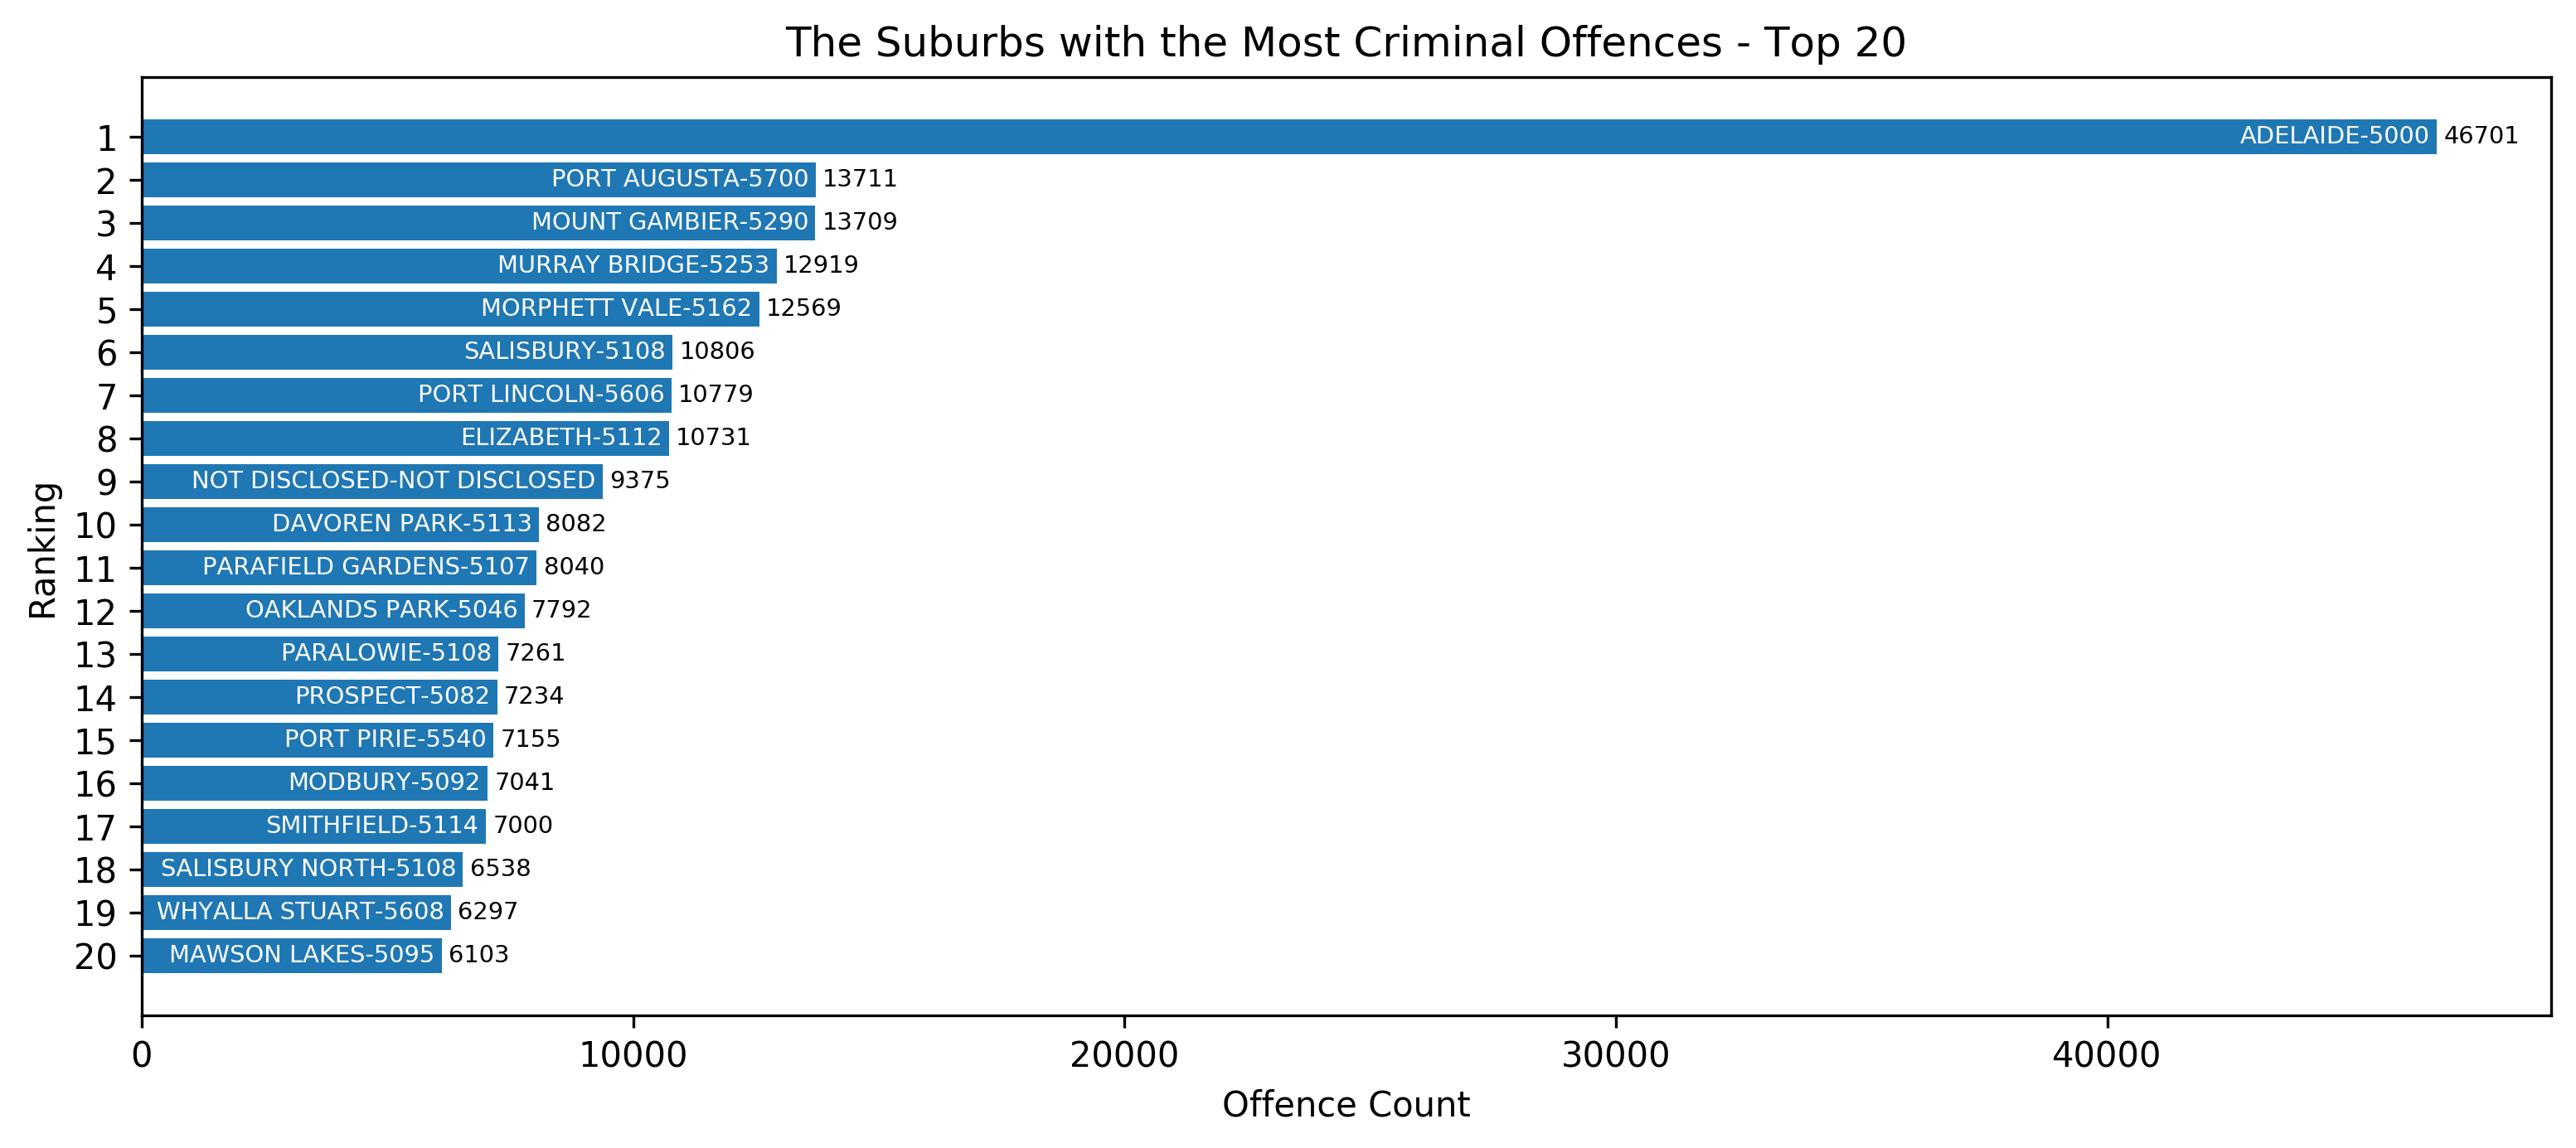

In [22]:
suburb_raw = crimes_converted.groupBy("Suburb - Incident",\
                                      "Postcode - Incident")\
                             .sum("Offence Count")\
                             .sort("sum(Offence Count)",\
                                   ascending=False)\
                             .withColumnRenamed("sum(Offence Count)",\
                                                "Offence Count")

suburb_cated = suburb_raw.withColumn("Suburb",\
                                     concat(suburb_raw["Suburb - Incident"],\
                                            lit("-"),\
                                            suburb_raw["Postcode - Incident"]))\
                         .drop("Suburb - Incident")\
                         .drop("Postcode - Incident")\
                         .select("Suburb", "Offence Count")\
                         .take(20)

suburbs = [i["Suburb"] for i in suburb_cated]
count = [i["Offence Count"] for i in suburb_cated]

fig, ax = plt.subplots(dpi=300)
rects = ax.barh(list(range(20, 0, -1)), count)

def autolabel(rects, prelabel, postlabel):
    i = 0
    for rect in rects:
        width = rect.get_width()
        ax.annotate(prelabel[i],\
                    xy=(rect.get_width(), rect.get_y()+0.5*rect.get_height()),\
                    xytext=(-2, 0),\
                    textcoords="offset points",\
                    ha='right', va='center',\
                    fontsize="x-small",\
                    color = "white")
        ax.annotate(postlabel[i],\
                    xy=(rect.get_width(), rect.get_y()+0.5*rect.get_height()),\
                    xytext=(2, 0),\
                    textcoords="offset points",\
                    ha='left', va='center',\
                    fontsize="x-small",\
                    color = "black")
        i += 1

ax.set_yticks(list(range(20, 0, -1)))
autolabel(rects, suburbs, count)
ax.set_yticklabels(list(range(20, 0, -1)[::-1]))
ax.set_xlabel("Offence Count")
ax.set_ylabel("Ranking")
ax.set_title("The Suburbs with the Most Criminal Offences - Top 20")

fig.set_size_inches(12.5,5)

Without any doubt, the city of Adelaide is the suburb where most criminal offences happened. This is probably because most of the population of South Australia is concentrated in the CBD, whereas other suburbs have relatively low population. Port Augusta, Mount Gambier, Murray Bridge, Morphett Vale, Salisbury, Port Lincoln and Elizabeth are the suburbs with more than 10,000 offences.

### Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

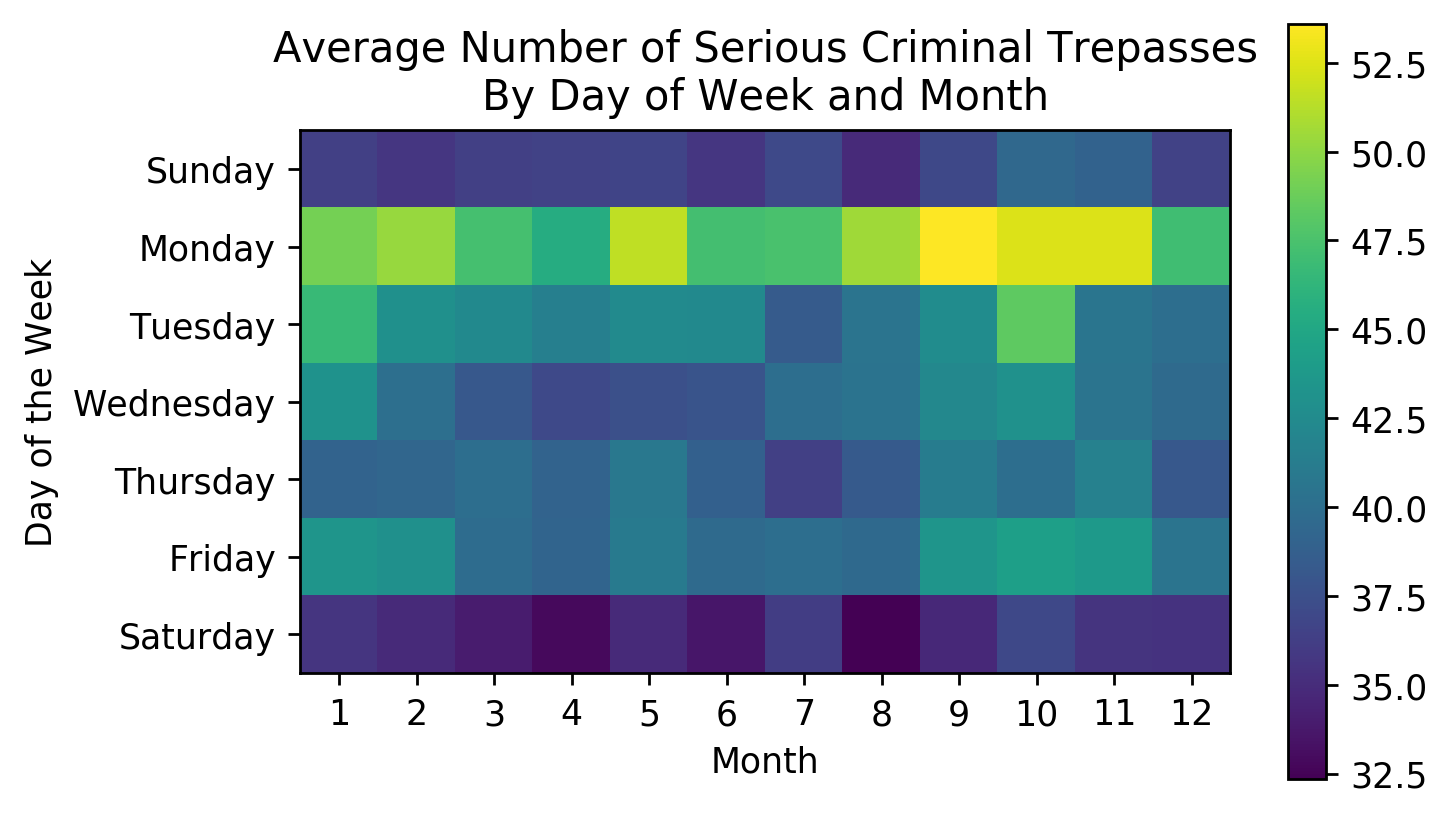

In [23]:
def day_of_week(day):
    if day == 1:
        return "Sunday"
    elif day == 2:
        return "Monday"
    elif day == 3:
        return "Tuesday"
    elif day == 4:
        return "Wednesday"
    elif day == 5:
        return "Thursday"
    elif day == 6:
        return "Friday"
    elif day == 7:
        return "Saturday"

dow = udf(day_of_week, StringType())

by_dow = crimes_converted.where(crimes_converted["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")\
                         .groupBy(month("Reported Date"),\
                                  dayofweek("Reported Date"))\
                         .sum("Offence Count")\
                         .sort("month(Reported Date)",\
                               "dayofweek(Reported Date)")


dow_converted = by_dow.withColumn("dayofweek(Reported Date)",\
                                  dow(col("dayofweek(Reported Date)"))).collect()

unique_daymonth = crimes_converted.where(crimes_converted["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")\
                                  .groupBy("Reported Date")\
                                  .count()\
                                  .groupBy(month("Reported Date"),\
                                           dayofweek("Reported Date"))\
                                  .count()\
                                  .sort("month(Reported Date)",\
                                        "dayofweek(Reported Date)")\
                                  .withColumn("dayofweek(Reported Date)",\
                                              dow(col("dayofweek(Reported Date)")))\
                                  .collect()



yticks = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
xticks = list(range(1, 13))
number = np.array([[i["count"] for i in unique_daymonth if i["dayofweek(Reported Date)"] == j ] for j in yticks])
data = np.array([[i["sum(Offence Count)"] for i in dow_converted if i["dayofweek(Reported Date)"] == j ] for j in yticks])
avg_data = data/number
fig, ax = plt.subplots(dpi=250)
ax.set_yticks(list(range(8)))
ax.set_yticklabels(yticks)
ax.set_xticks(list(range(13)))
ax.set_xticklabels(xticks)
ax.set_ylabel("Day of the Week")
ax.set_xlabel("Month")
ax.set_title("Average Number of Serious Criminal Trepasses\nBy Day of Week and Month")
im = ax.imshow(avg_data)
cb = plt.colorbar(im)

There are two very significant divisions in this graph: the division between weekend and weekdays, and the division between summer months and winter months. Among the weekdays, Monday is the day with highest rate of serious criminal trepasses, since most people stay at home during weekends. In average, warmer months (September to February) has higher rates of serious criminal trepasses.

---
This is the end of Part B.